CODE BLOCK: 1

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

CODE BLOCK: 2

In [30]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For GPU
device = torch.device("cuda" if cuda else "cpu")
print("CUDA Available?", cuda)

CUDA Available? True
CUDA Available? True


CODE BLOCK: 3

In [83]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1407,), (0.4081,))
    ])

CODE BLOCK: 4

In [84]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

CODE BLOCK: 5

In [85]:
batch_size = 1000

train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

CODE BLOCK: 6

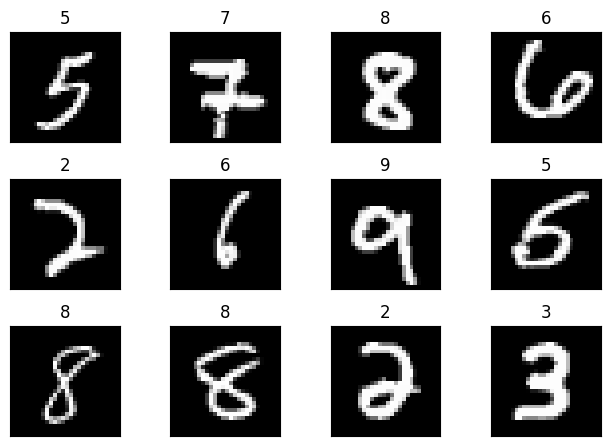

In [86]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [95]:
class Net(nn.Module):
  #This defines the structure of the NN.
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
    self.bn1   = nn.BatchNorm2d(16)

    self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
    self.bn2   = nn.BatchNorm2d(32)

    self.fc1 = nn.Linear(1568, 128)
    self.fc2 = nn.Linear(128, 10)
    self.dropout = nn.Dropout(0.25)

  def forward(self, x):
    x = F.relu(self.bn1(self.conv1(x)))
    x = F.max_pool2d(x, 2)
    x = F.relu(self.bn2(self.conv2(x)))
    x = F.max_pool2d(x, 2)
    x = x.view(-1, 32*7*7)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x

CODE BLOCK: 8

In [88]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [89]:
from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)

    test_loss /= len(test_loader)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)



CODE BLOCK: 10

In [98]:
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Scheduler that reduces LR if validation accuracy plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=1, factor=0.5)

max_epochs = 2
target_acc = 95.0

for epoch in range(1, max_epochs+1):
    print(f'Epoch {epoch}')
    train(model, device, train_loader, optimizer, criterion)
    test(model, device, test_loader, criterion)


    scheduler.step(test_acc[-1])


    if test_acc[-1] >= target_acc:
        print(f"✅ Target accuracy {target_acc}% reached at epoch {epoch}. Stopping training.")
        break

Epoch 1


Train: Loss=0.0605 Batch_id=468 Accuracy=94.61: 100%|██████████| 469/469 [00:13<00:00, 35.51it/s]


✅ Target accuracy 95.0% reached at epoch 1. Stopping training.


CODE BLOCK: 11

Text(0.5, 1.0, 'Test Accuracy')

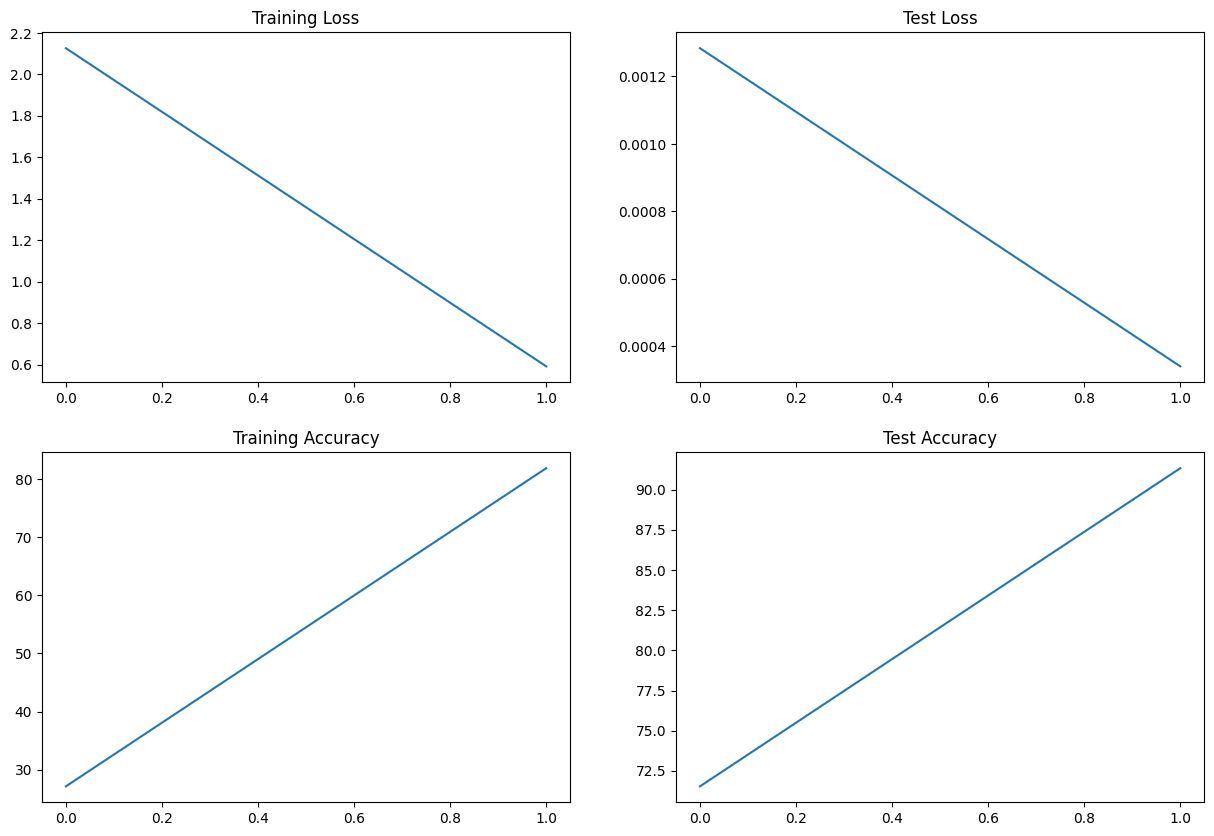

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))